In [1]:
from poppy.creatures import PoppyHumanoid

poppy = PoppyHumanoid(simulator='vrep')

%pylab inline
import time

Populating the interactive namespace from numpy and matplotlib


Prepared poppy for experiments

In [2]:
poppy.head_y.goto_position(0, 4, wait=False)
poppy.r_shoulder_y.goto_position(0, 4, wait=False)
poppy.l_shoulder_y.goto_position(0, 4, wait=True)
poppy.l_shoulder_x.goto_position(20, 4, wait=False)
poppy.r_shoulder_x.goto_position(-20, 4, wait=True)

Track the head like an IMU could do. On the next graph, you can see the pushing force every two minutes on the chest.

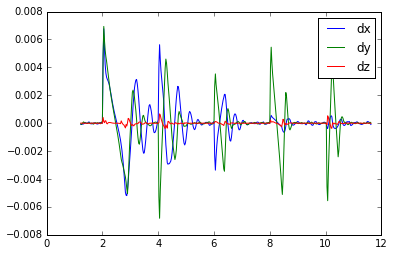

In [7]:
list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

pos = poppy.get_object_position('head_visual')
pos_x=pos[0]
pos_y=pos[1]
pos_z=pos[2]

t0 = time.time()

while time.time() - t0 < 30:
    pos = poppy.get_object_position('head_visual')
    
    
    if pos_x != pos[0]:
        decalage_x=pos[0]-pos_x
        decalage_y=pos[1]-pos_y
        decalage_z=pos[2]-pos_z
    
    

        list_pos_x.append(decalage_x)
        list_pos_y.append(decalage_y)
        list_pos_z.append(decalage_z)
    
        pos_x = pos[0]
        pos_y = pos[1]
        pos_z = pos[2]
    
        t.append(poppy.current_simulation_time)
    
    time.sleep(0.01)
    
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)


legend(('dx', 'dy','dz'))

Changing the reference frame from absolute to a frame relative to poppy (if you want to know more on matrix of rotation, you have [this tutorial](http://nbviewer.ipython.org/github/jjehl/poppy_balance/blob/master/tutorial_rotation_matrix.ipynb). Choosing the frame oriented by visual chest. The graph shows the same movement but in the relative frame and the arms try to decrease the ocillation by balancing the movement in the opposite direction. 

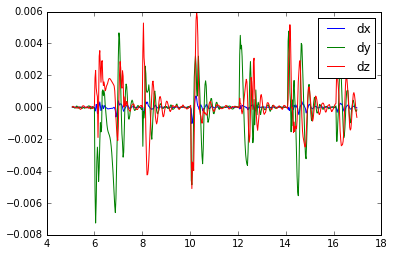

In [10]:
def rotate_matrix(a,b,g):
    Rx = np.mat([[1,0,0], [0,cos(a),-sin(a)], [0,sin(a),cos(a)]])
    Ry = np.mat([[cos(b),0,sin(b)], [0,1,0], [-sin(b),0,cos(b)]])
    Rz = np.mat([[cos(g),-sin(g),0], [sin(g),cos(g),0], [0,0,1]])
    Rot = Rx*Ry*Rz
    return Rot

list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

pos0 = np.mat(poppy.get_object_position('head_visual')).transpose()
t0 = time.time()
time.sleep(0.01)

while time.time() - t0 < 60:
    pos1 = np.mat(poppy.get_object_position('head_visual')).transpose()
    if any(pos1 != pos0):
        d_pos = pos1-pos0
        
        #make a rotation to d_pos to transpose the movement in a relative frame (frame of chest_visual)
        orient_chest = poppy.get_object_orientation('chest_visual')
        Rot=rotate_matrix(-orient_chest[0],-orient_chest[1],-orient_chest[2])
        d_pos=Rot*d_pos
        
        #balance the movement with an opposite movement of the arm
        #le terme instantanée doit être ajouté à un terme intégré sur les 10 derniers mouvements
        poppy.r_shoulder_y.goal_position = -d_pos[1]*2000
        poppy.l_shoulder_y.goal_position = -d_pos[1]*2000
        poppy.r_shoulder_x.goal_position = -20-d_pos[2]*2000
        poppy.l_shoulder_x.goal_position = 20-d_pos[2]*2000
        
        list_pos_x.append(float(d_pos[0]))
        list_pos_y.append(float(d_pos[1]))
        list_pos_z.append(float(d_pos[2]))
        t.append(poppy.current_simulation_time)
        pos0 = pos1
    time.sleep(0.01)

  
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)
legend(('dx', 'dy','dz'))

The balance use only the speed of the movement (i.e the movement of the arm is only proportional to the speed of the move of the head. It could be better to use also the acceleration and the position (integration of speed). So to be continued...